In [1]:
import numpy as np
import pyart
import matplotlib.pyplot as plt
import os
#import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture
import pickle
from netCDF4 import num2date, date2num
import math

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd
import metpy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.io.img_tiles as cimgt
import glob
import pandas as pd
from cartopy.io.img_tiles import MapboxTiles
#from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:

def parse_isochrone_source(filename):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    return ''.join(fn_list[-1])

def parse_isochrone_time(filename,origin_tz=None):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    strdate, strtime = ''.join(fn_list[1:4]), fn_list[4]
    dt = pd.to_datetime(strdate+strtime, format='%d%m%Y%H%M')
    if origin_tz is not None:
        dt = dt.tz_localize(tz=origin_tz)
        dt = dt.tz_convert('utc')
    else:
        dt = dt.tz_localize(tz='utc')
    return dt

def parse_isochrones(fls):
    isochrone_df = pd.DataFrame({'paths':fls})

    isochrone_df['source'] = isochrone_df['paths'].apply(parse_isochrone_source)

    final_isochrone = isochrone_df[isochrone_df.source == 'final']
    isochrone_df = isochrone_df[isochrone_df.source != 'final'].copy()

    isochrone_df['datetime'] = isochrone_df['paths'].apply(parse_isochrone_time,origin_tz='Australia/Brisbane')
    isochrone_df = isochrone_df.set_index(['datetime'])
    
    start_time = isochrone_df.index.min()
    end_time = isochrone_df.index.max()
    print('Data collection duration: {}'.format(end_time-start_time))
    
    return final_isochrone, isochrone_df

def load_shapefiles_into_gdf(isochrone_df):

    isochrones_gdf = gpd.GeoDataFrame()

    for dt, row in isochrone_df.iterrows():
        iso = gpd.read_file(row['paths'])
        iso['datetime'] = dt
        iso['source'] = row['source']
        if bool(iso.crs):
            isochrones_gdf = isochrones_gdf.append(iso)
        else: 
            print('File is missing crs: {}'.format(row['paths']))
            print('Skipping...')
        
    isochrones_gdf = isochrones_gdf[['geometry','datetime','source']].reset_index()
        
    return isochrones_gdf
def add_isochrones(ax,final_edge='grey'):
    handles = []
    labels = []
    
    ax.add_geometries(final_gdf['geometry'],edgecolor=final_edge,facecolor='None',crs=ccrs.PlateCarree())
    handles.append(Line2D([0], [0], color=final_edge, lw=2))
    labels.append('Final perimeter')

    color=iter(plt.cm.rainbow_r(np.linspace(0,1,len(isochrones_gdf))))
    for i, row in isochrones_gdf.iloc[::-1].iterrows():
        c=next(color)
        ax.add_geometries([row['geometry']],facecolor=c,crs=ccrs.PlateCarree())
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=c))
        labels.append('{} ({})'.format(row['datetime'].tz_convert(target_tz).strftime(time_str_format_map),row['source']))
    
    return handles, labels

In [3]:
fls = glob.glob('./datasets/Perimeter Shapefiles/*.shp')
fls.sort()
final_isochrone, isochrone_df = parse_isochrones(fls)
final_gdf = gpd.read_file(final_isochrone.iloc[0].paths)
isochrones_gdf = load_shapefiles_into_gdf(isochrone_df)

Data collection duration: 1 days 12:58:00
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_5_12_2016_1348_MODIS.shp
Skipping...
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_6_12_2016_1338_VIIRS.shp
Skipping...


In [4]:
 with open("./mbox_key.txt", "r") as f:
        mbox_key = f.read()

In [5]:
min_lon, min_lat, max_lon, max_lat = [151,-28.3,151.58,-28.04]
x0x1y0y1 = [min_lon, max_lon, max_lat, min_lat]

In [6]:
def formatmap(ax):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

## Create Cartopy basemap with mapbox tiles

In [8]:
crs_proj4 = ccrs.PlateCarree().proj4_init
#isochrones_gdf = isochrones_gdf.to_crs(crs_proj4)

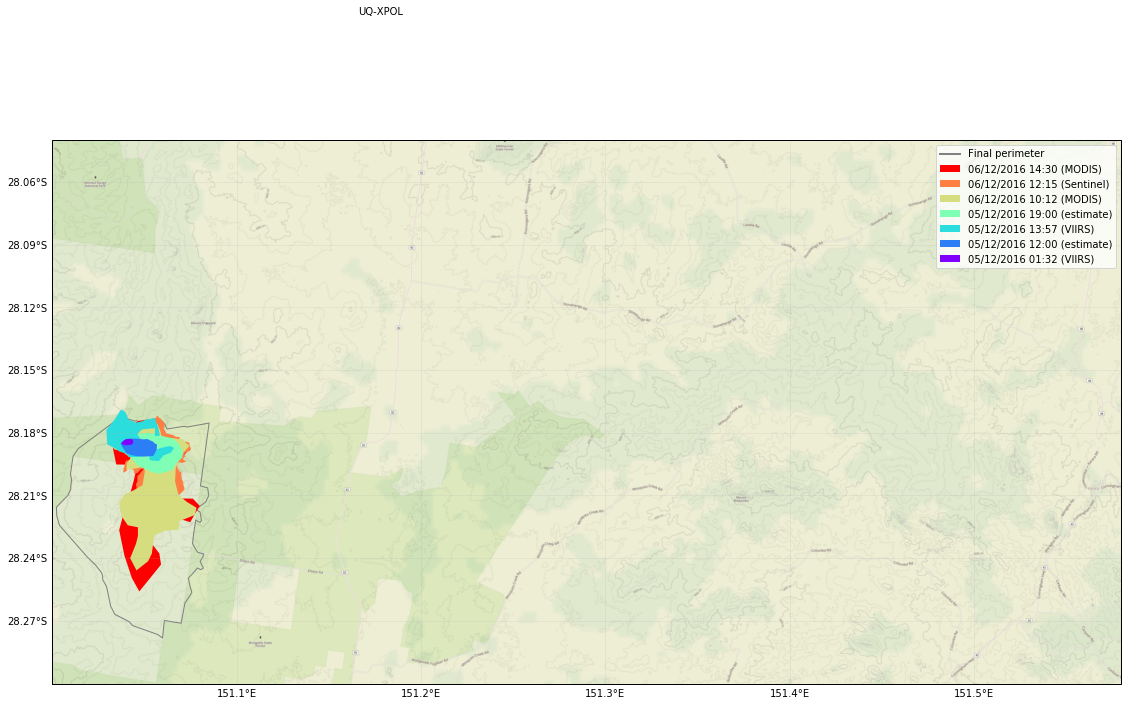

In [11]:
target_tz = 'Australia/Brisbane'
target_tz_name = 'AEST'
time_str_format_map = '%d/%m/%Y %H:%M'

fig = plt.figure(figsize=(20,10))
tiler = MapboxTiles(mbox_key,'outdoors')
mercator = tiler.crs

ax = plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
ax.add_image(tiler, 13,interpolation='bilinear')
ax = formatmap(ax)

handles, labels = add_isochrones(ax)

xpol_lat, xpol_lon = -27.98, 151.19

plt.plot(xpol_lon, xpol_lat,
         color='blue', marker='o',
         transform=ccrs.PlateCarree()
         )

# plt.text(xpol_lon, xpol_lat, 'UQ-XPOL',
#          horizontalalignment='right',
#          transform=ccrs.Geodetic())

#plt.legend(handles,labels,ncol=len(isochrones_gdf), bbox_to_anchor=(0, 1),loc='lower left')
plt.legend(handles,labels)


plt.show()



In [ ]:


fig = plt.figure(figsize=(20,10))

ax = plt.axes(projection=mercator)
ax.add_image(tiler, 8,interpolation='bilinear')

#min_lon, min_lat, max_lon, max_lat = [151,-28.3,151.58,-28.04]
x0x1y0y1 = [lightning.lon.min(), lightning.lon.max(), lightning.lat.max(), lightning.lat.min()]
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
ax = formatmap(ax)
plt.show()


NameError: name 'lightning' is not defined

In [496]:
def add_radar_contours(radar,tilt=0,field='RHOHV',levels=[.9],sigma=3):
    data = radar.get_field(0,'RHOHV')
    lat, lon, alt = radar.get_gate_lat_lon_alt(0)
    if sigma is not None:
        data = spyi.gaussian_filter(data, sigma=sigma)
    levels = [.9]
    ax.contour(lon, lat, data, levels, 
                linewidths=1, colors='k',
                linestyles='--', antialiased=True,
                transform=ccrs.PlateCarree())
    
def radar_plot(path,field,tilt,apply_gatefilter=True,contour_field=None,**kwargs):
    myradar = pyart.aux_io.read_odim_h5(path, file_field_names=True)

    if field == 'GMM':
        model_name = 'GMM_n' + str(models[k].n_components)
        myradar.add_field(model_name,predict_labels(myradar,models[k],filt=False))

    #radar_ts = num2date(myradar.time['data'][0] + tz* 60.*60., myradar.time['units'])

    if apply_gatefilter:
        gatefilter = give_gatefilter(myradar,despecke=50,mindop=0.25,maxdop=15,snr=2,minref=15)
    else:
        gatefilter = None
    my_display = pyart.graph.RadarMapDisplay(myradar)

    im = my_display.plot_ppi_map(field,tilt,**dict(kwargs, gatefilter=gatefilter))
    
    radar_metadata = {}
    radar_metadata['timestamp'] = pd.to_datetime(num2date(myradar.time['data'][0], myradar.time['units']),utc=True)
    radar_metadata['elev'] = myradar.get_elevation(tilt)[0]
    if contour_field is not None:
        add_radar_contours(myradar,tilt,field=contour_field)
    return radar_metadata, my_display

## Plot a single scan in it's own fig

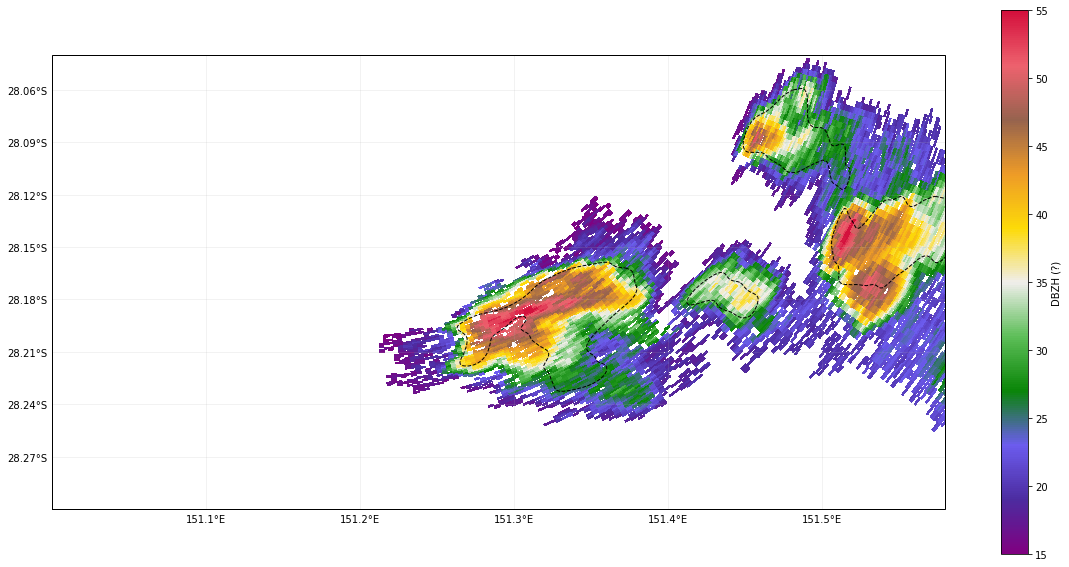

In [498]:
field = 'DBZH'
tilt=2

fig = plt.figure(figsize=(20,10))
tiler = MapboxTiles(mbox_key,'outdoors')
mercator = tiler.crs
ax = plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
#ax.add_image(tiler, 13,interpolation='bilinear')
ax = formatmap(ax)



plot_args = {'vmin':15, 
            'vmax':55, 
            'projection':mercator,
            'ax':ax,
            'cmap':pyart.graph.cm.RRate11,
            #'gatefilter':gatefilter,
            'colorbar_flag':True,
            'title_flag':False}

radar_metadata = radar_plot(radar_df_30M.paths.iloc[-1],field,tilt,contour_field='RHOHV',**plot_args)


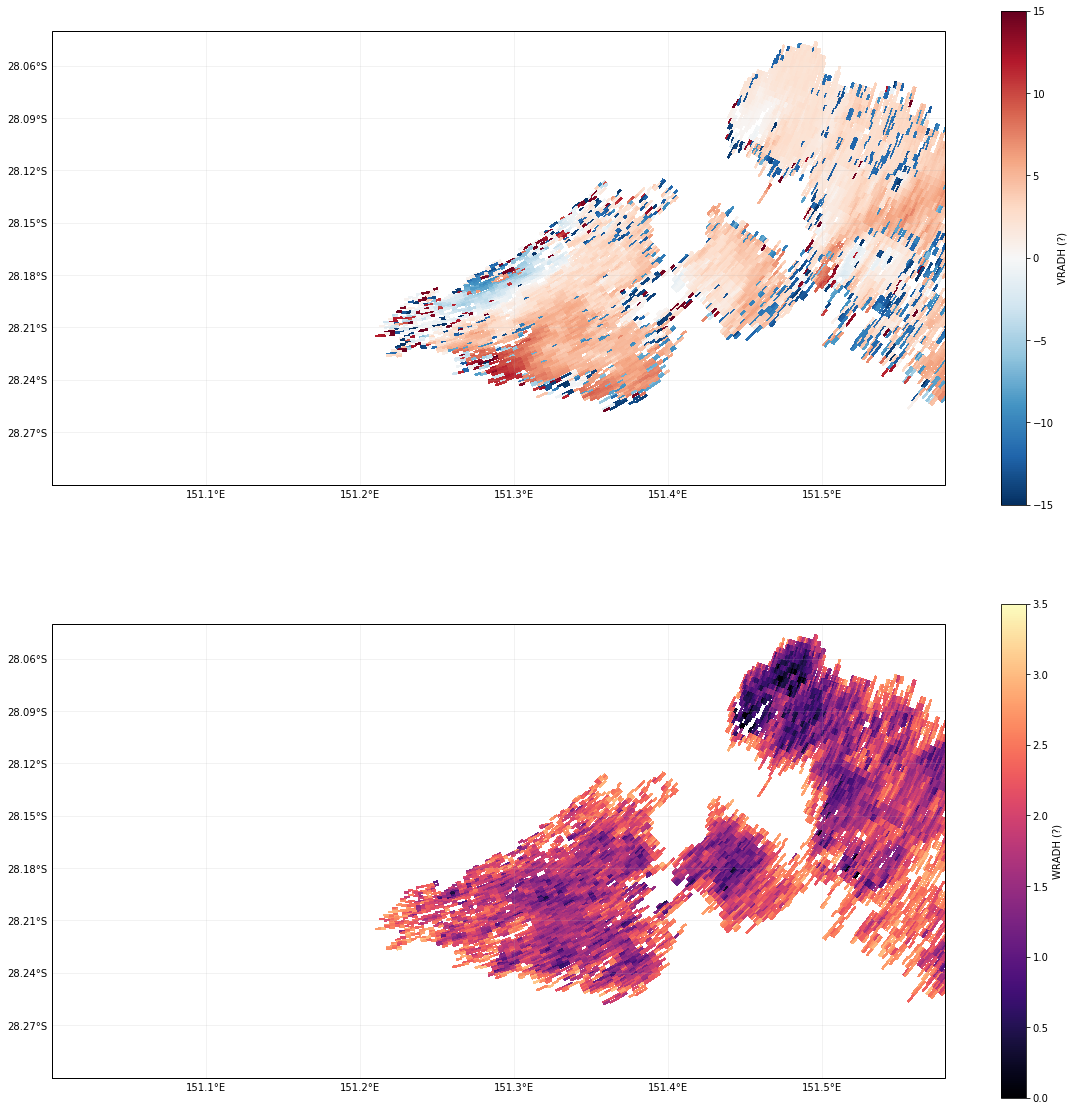

In [324]:
tilt=0

#fig = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(20,20),sharex=True,subplot_kw={'projection': mercator})
tiler = MapboxTiles(mbox_key,'outdoors')
mercator = tiler.crs

ax = axs[0]#plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
#ax.add_image(tiler, 13,interpolation='bilinear')
ax = formatmap(ax)

field = 'VRADH'
plot_args = {'vmin':-15, 
            'vmax':15, 
            'projection':mercator,
            'ax':ax,
            'cmap':'RdBu_r',
            #'gatefilter':gatefilter,
            'colorbar_flag':True,
            'title_flag':False}
    
radar_plot(radar_df_30M.paths.iloc[-1],field,tilt,**plot_args)

ax = axs[1]#plt.axes(projection=mercator)
ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
#ax.add_image(tiler, 13,interpolation='bilinear')
ax = formatmap(ax)

field = 'WRADH'
plot_args = {'vmin':0, 
            'vmax':3.5, 
            'projection':mercator,
            'ax':ax,
            'cmap':'magma',
            #'gatefilter':gatefilter,
            'colorbar_flag':True,
            'title_flag':False}
    
radar_plot(radar_df_30M.paths.iloc[-1],field,tilt,**plot_args)

## Plot all in plot subset in subplots

In [292]:
def apply_subplot_ticks(ax):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_bottom = gl.ylabels_left = gl.xlabels_top = gl.ylabels_right = False
    if ax in axs[-1]:
        gl.xlabels_bottom = True
        gl.xformatter = LONGITUDE_FORMATTER

    if ax in axs[:,0]:
        gl.ylabels_left = True
        gl.yformatter = LATITUDE_FORMATTER

In [326]:
field='DBZH'
tilt=1
plot_args = {'vmin':15, 
            'vmax':55, 
            'projection':mercator,
            'cmap':pyart.graph.cm.RRate11,
            'colorbar_flag':False,
            'title_flag':False}

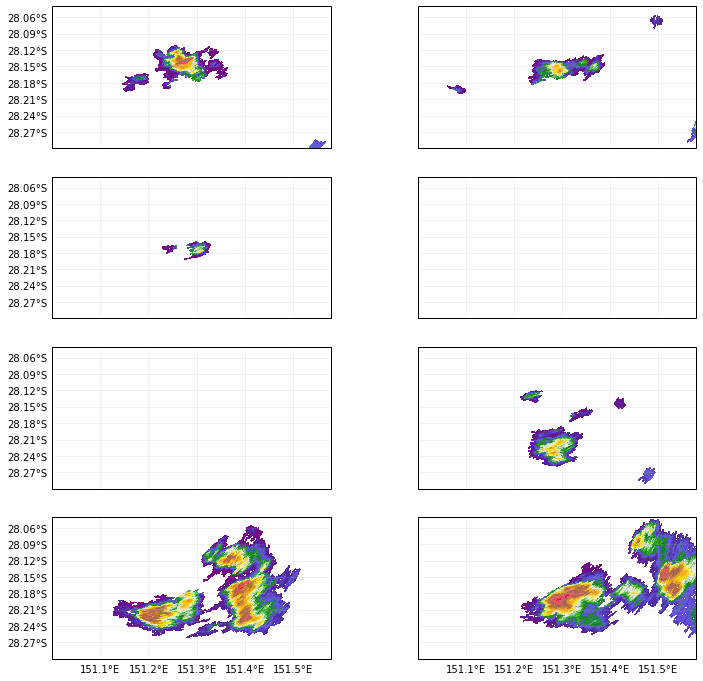

In [317]:
tiles = False
nrow = 4; ncol = 2;
assert nrow*ncol == len(radar_df_30M)
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(12,12),sharex=True,subplot_kw={'projection': mercator})

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
    if tiles:
        ax.add_image(tiler, 13,interpolation='bilinear')
    plot_args['ax']=ax
    radar_plot(radar_df_30M.paths.iloc[i],field,tilt,apply_gatefilter=True,**plot_args)
    apply_subplot_ticks(ax)

plt.show()

In [373]:
from string import ascii_lowercase as alphabet


'a'

<>:38: DeprecationWarning: invalid escape sequence \m
<>:38: DeprecationWarning: invalid escape sequence \m
<>:38: DeprecationWarning: invalid escape sequence \m
<ipython-input-442-0e8469768a82>:38: DeprecationWarning: invalid escape sequence \m
  im.plot_colorbar(cax=cbar_ax,label='$\mathregular{\mathit{Z_{H}}}$ (dBZ)')


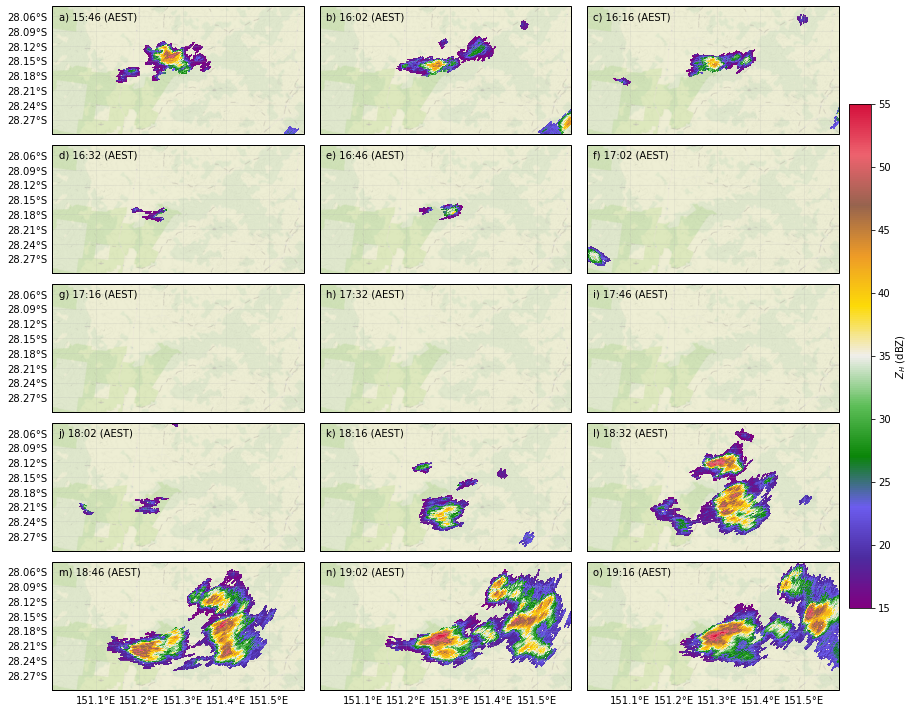

In [442]:
tiles = True
save = True
nrow = 5; ncol = 3;
assert nrow*ncol == len(radar_df_15M)
target_tz = 'Australia/Brisbane'
target_tz_name = 'AEST'
time_str_format = '%H:%M'
field='DBZH'
tilt=1
plot_args = {'vmin':15, 
            'vmax':55, 
            'projection':mercator,
            'cmap':pyart.graph.cm.RRate11,
            'colorbar_flag':False,
            'title_flag':False}



fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(12,10),sharex=True,subplot_kw={'projection': mercator})

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
    if tiles:
        ax.add_image(tiler, 13,interpolation='bilinear')
    plot_args['ax']=ax
    radar_metadata, im = radar_plot(radar_df_15M.paths.iloc[i],field,tilt,apply_gatefilter=True,**plot_args)
    apply_subplot_ticks(ax)
    ds_string = '{} ({})'.format(radar_metadata['timestamp'].tz_convert(target_tz).strftime(time_str_format),
                                 target_tz_name)
    ax.text(.025,.9,'{}) {}'.format(alphabet[i],ds_string),
        horizontalalignment='left',
        transform=ax.transAxes)
    

fig.canvas.draw()
plt.tight_layout()
cbar_ax = fig.add_axes([0.99, 0.15, 0.025, 0.7])
im.plot_colorbar(cax=cbar_ax,label='$\mathregular{\mathit{Z_{H}}}$ (dBZ)')
if save:
    plt.savefig('./fig_reflectivity_subplot_15M_{}.png'.format(str(radar_metadata['elev']).replace('.','p')),dpi=300)
plt.show()